Importing modules

In [162]:
%pip install pandas
%pip install matplotlib
%pip install scikit-learn

# Save requirements.txt
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [163]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Setting up data prep variables

In [164]:
year_col = "Quarter_Year"
index_suff = "_HPI"
price_suff = "_Standardised_Price"

price_min = 0
index_min = 0

q_year_regex = r"^Q[1-4]\s\d{4}$"

Parse Quarter_Year strings into Year (int), Quarter (int), Period_end (datetime) and TimeLabel

In [166]:
def parse_quarter_year(qy: pd.Series) -> pd.DataFrame:
    qy = qy.astype("string").str.strip()

    bad = ~qy.str.match(q_year_regex, na=False)
    if bad.any():
        examples = qy[bad].dropna().unique()[:10]
        raise ValueError(f"Quarter_Year contains invalid values, examples: {examples}")
    
    quarter = qy.str.extract(r"^Q([1-4])\s(\d{4})$")[0].astype(int)
    year = qy.str.extract(r"^Q([1-4])\s(\d{4})$")[1].astype(int)

    q_end_month = quarter.map({1: 3, 2: 6, 3: 9, 4: 12})
    period_end = pd.to_datetime(
        dict(year=year, month=q_end_month, day=1)
    ) + pd.offsets.MonthEnd(0)

    time_label = year.astype(str) + "Q" + quarter.astype(str)

    return pd.DataFrame({"Year": year, "Quarter": quarter, "Period_End": period_end, "TimeLabel": time_label})

Convert wide dataset to long, converting format from:
"Quarter_Year", "Belfast_HPI", "Belfast_Standardised_Price" ... into:
Quarter_Year, LGD, HPI, Standardised_Price

In [167]:
def wide_to_long_lgd(df: pd.DataFrame) -> pd.DataFrame:
    if year_col not in df.columns:
        raise KeyError(f"Missing required column: {year_col}")
    
    # Identify LGD columns by suffix
    index_cols = [c for c in df.columns if c.endswith(index_suff)]
    price_cols = [c for c in df.columns if c.endswith(price_suff)]

    if not index_cols and not price_cols:
        raise ValueError("No LGD HPI/Price columns found. Check suffixes / column names.")
    
    # Determine LGD names by removing suffix
    lgds_from_index = {c[: -len(index_suff)] for c in index_cols}
    lgds_from_price = {c[: -len(price_suff)] for c in price_cols}
    lgds = sorted(lgds_from_index.union(lgds_from_price))

    # Build long records
    long_frame = []
    for lgd in lgds:
        cols = [year_col]
        index_col = f"{lgd}{index_suff}"
        price_col = f"{lgd}{price_suff}"

        tmp = df[[year_col]].copy()
        tmp["LGD"] = lgd
        
        tmp["HPI"] = df[index_col] if index_col in df.columns else np.nan
        tmp["Standardised_Price"] = df[price_col] if price_col in df.columns else np.nan

        long_frame.append(tmp)

    out = pd.concat(long_frame, ignore_index=True)

    # Drop any completely NULL rows
    out = out.dropna(subset=["HPI", "Standardised_Price"], how="all")

    return out

Enforce data types, convert Quarter_Year into multiple columns and apply cleaning

In [168]:
def enforce_types_and_clean(df_long: pd.DataFrame) -> pd.DataFrame:
    # Clean strings of whitespace
    df_long[year_col] = df_long[year_col].astype("string").str.strip()
    df_long["LGD"] = df_long["LGD"].astype("string").str.strip()

    # Parse time
    time_df = parse_quarter_year(df_long[year_col])
    df_long = pd.concat([df_long.reset_index(drop=True), time_df], axis=1)

    # Ensure Index and Price are numeric
    df_long["HPI"] = pd.to_numeric(df_long["HPI"], errors="coerce")
    df_long["Standardised_Price"] = pd.to_numeric(df_long["Standardised_Price"], errors="coerce")

    # Enforce expected datatypes
    df_long["Year"] = df_long["Year"].astype("int64")
    df_long["Quarter"] = df_long["Quarter"].astype("int64")
    df_long["LGD"] = df_long["LGD"].astype("category")

    # Number range checking (log errors)
    bad_price = (df_long["Standardised_Price"].notna()) & (df_long["Standardised_Price"] <= price_min)
    bad_index = (df_long["HPI"].notna()) & (df_long["HPI"] <= index_min)

    if bad_price.any():
        sample = df_long.loc[bad_price, ["LGD", year_col, "Standardised_Price"]].head(10)
        raise ValueError(f"Found impossible Standardised_Price values (sample):\n{sample}")
    
    if bad_index.any():
        sample = df_long.loc[bad_index, ["LGD", year_col, "HPI"]].head(10)
        raise ValueError(f"Found impossible HPI values (sample):\n{sample}")
    
    # Sort for time
    df_long = df_long.sort_values(["LGD", "Period_End"]).reset_index(drop=True)

    return df_long

Validate time and duplicates for LGDs

In [169]:
def validate_time_series(df_long: pd.DataFrame) -> None:
    # Check for duplicate LGD x Quarter_Year
    dup = df_long.duplicated(subset=["LGD", year_col])
    if dup.any():
        sample = df_long.loc[dup, ["LGD", year_col]].head(10)
        raise ValueError(f"Duplicate LGD x Quarter_Year rows found (sample):\n{sample}")
    
    # Check for any missing quarters per LGD
    for lgd, g in df_long.groupby("LGD", observed=True):
        g = g.sort_values("Period_End")
        diffs = g["Period_End"].diff().dropna()
        p = g["Period_End"].dt.to_period("Q")
        if not (p[1:].reset_index(drop=True) == (p.shift(1)[1:].reset_index(drop=True) + 1)).all():
            missing_info = pd.DataFrame({"LGD": [lgd], "note": ["Non-consecutive quarters detected"]})
            raise ValueError(f"Time continuity issue for {lgd}. {missing_info.to_string(index=False)}")

Add lagged features per LGD for future forecasting

In [170]:
def add_lag_features(df_long: pd.DataFrame, lags=(1,)) -> pd.DataFrame:
    df = df_long.copy()
    for lag in lags:
        df[f"Price_lag_{lag}"] = df.groupby("LGD", observed=True)["Standardised_Price"].shift(lag)
        df[f"HPI_lag_{lag}"] = df.groupby("LGD", observed=True)["HPI"].shift(lag)
    return df

Sorting function when needed

In [171]:
def safe_sort(df: pd.DataFrame) -> pd.DataFrame:
    return df.sort_values(["LGD", "Period_End"]).reset_index(drop=True)

Main combined data cleaning/prepping pipeline:
wide to long, parse time, enforce datatypes, validate and add lag features

In [172]:
def clean_lgd_dataset(df_raw: pd.DataFrame) -> pd.DataFrame:
    long_df = wide_to_long_lgd(df_raw)
    long_df = enforce_types_and_clean(long_df)
    validate_time_series(long_df)

    long_df = add_lag_features(long_df, lags=(1,))

    return long_df

Bring in raw data

In [173]:
csv_path = Path("../Project/Data/standardised-price-and-index-by-lgd-q1-2005-q2-2025.csv")
csv_path.parent.mkdir(parents=True, exist_ok=True)

df_raw = pd.read_csv(csv_path)

df_raw.head()

,Quarter_Year,Antrim_and_Newtownabbey_HPI,Antrim_and_Newtownabbey_Standardised_Price,Ards_and_North_Down_HPI,Ards_and_North_Down_Standardised_Price,Armagh_City_Banbridge_and_Craigavon_HPI,Armagh_City_Banbridge_and_Craigavon_Standardised_Price,Belfast_HPI,Belfast_Standardised_Price,Causeway_Coast_and_Glens_HPI,...,Fermanagh_and_Omagh_HPI,Fermanagh_and_Omagh_Standardised_Price,Lisburn_and_Castlereagh_HPI,Lisburn_and_Castlereagh_Standardised_Price,Mid_and_East_Antrim_HPI,Mid_and_East_Antrim_Standardised_Price,Mid_Ulster_HPI,Mid_Ulster_Standardised_Price,Newry_Mourne_and_Down_HPI,Newry_Mourne_and_Down_Standardised_Price
0,Q1 2005,64.757496,107490.977137,68.035173,123662.111857,65.161339,99340.285628,66.578100,99461.799366,61.758582,...,66.315555,104020.362605,63.465388,123086.740895,66.148047,97052.531074,70.370037,108034.687663,62.377440,108230.240612
1,Q2 2005,64.640971,107297.556283,70.586997,128300.360502,67.761688,103304.590567,67.078251,100208.980689,64.111471,...,71.048889,111444.912578,66.247250,128481.969414,67.569325,99137.831870,75.625814,116103.551806,69.279663,120206.194262
2,Q3 2005,69.967466,116139.007059,71.548867,130048.673876,70.107196,106880.382611,73.096557,109199.798043,69.259431,...,76.297142,119677.145886,70.608063,136939.466963,72.942191,107020.911488,80.564993,123686.361607,72.540480,125863.992852
3,Q4 2005,72.556285,120436.188420,74.510047,135430.975548,73.973592,112774.812669,73.839011,110308.958726,71.626217,...,79.255195,124317.049677,73.616850,142774.800173,74.129865,108763.467727,83.480973,128163.083083,76.495803,132726.819869
4,Q1 2006,73.567257,122114.300181,76.477755,139007.520955,77.643195,118369.224899,74.904865,111901.250958,74.544335,...,82.148565,128855.492292,73.108969,141789.801670,74.967587,109992.575653,88.751255,136254.214241,78.860427,136829.645099


Check info of raw data

In [174]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 23 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Quarter_Year                                            82 non-null     object 
 1   Antrim_and_Newtownabbey_HPI                             82 non-null     float64
 2   Antrim_and_Newtownabbey_Standardised_Price              82 non-null     float64
 3   Ards_and_North_Down_HPI                                 82 non-null     float64
 4   Ards_and_North_Down_Standardised_Price                  82 non-null     float64
 5   Armagh_City_Banbridge_and_Craigavon_HPI                 82 non-null     float64
 6   Armagh_City_Banbridge_and_Craigavon_Standardised_Price  82 non-null     float64
 7   Belfast_HPI                                             82 non-null     float64
 8   Belfast_Standardised_Price                

Clean the data using outlined pipeline above:

In [175]:
df_clean = clean_lgd_dataset(df_raw)

df_clean.head()

,Quarter_Year,LGD,HPI,Standardised_Price,Year,Quarter,Period_End,TimeLabel,Price_lag_1,HPI_lag_1
0,Q1 2005,Antrim_and_Newtownabbey,64.757496,107490.977137,2005,1,2005-03-31,2005Q1,NaN,NaN
1,Q2 2005,Antrim_and_Newtownabbey,64.640971,107297.556283,2005,2,2005-06-30,2005Q2,107490.977137,64.757496
2,Q3 2005,Antrim_and_Newtownabbey,69.967466,116139.007059,2005,3,2005-09-30,2005Q3,107297.556283,64.640971
3,Q4 2005,Antrim_and_Newtownabbey,72.556285,120436.188420,2005,4,2005-12-31,2005Q4,116139.007059,69.967466
4,Q1 2006,Antrim_and_Newtownabbey,73.567257,122114.300181,2006,1,2006-03-31,2006Q1,120436.188420,72.556285


Validate the cleaned data

In [176]:
df_clean.shape

(902, 10)

In [177]:
df_clean["LGD"].unique()

['Antrim_and_Newtownabbey', 'Ards_and_North_Down', 'Armagh_City_Banbridge_and_Craigavon', 'Belfast', 'Causeway_Coast_and_Glens', ..., 'Fermanagh_and_Omagh', 'Lisburn_and_Castlereagh', 'Mid_Ulster', 'Mid_and_East_Antrim', 'Newry_Mourne_and_Down']
Length: 11
Categories (11, string): [Antrim_and_Newtownabbey, Ards_and_North_Down, Armagh_City_Banbridge_and_Craigavon, Belfast, ..., Lisburn_and_Castlereagh, Mid_Ulster, Mid_and_East_Antrim, Newry_Mourne_and_Down]

In [178]:
df_clean.sort_values(["LGD", "Period_End"]).head(10)

,Quarter_Year,LGD,HPI,Standardised_Price,Year,Quarter,Period_End,TimeLabel,Price_lag_1,HPI_lag_1
0,Q1 2005,Antrim_and_Newtownabbey,64.757496,107490.977137,2005,1,2005-03-31,2005Q1,NaN,NaN
1,Q2 2005,Antrim_and_Newtownabbey,64.640971,107297.556283,2005,2,2005-06-30,2005Q2,107490.977137,64.757496
2,Q3 2005,Antrim_and_Newtownabbey,69.967466,116139.007059,2005,3,2005-09-30,2005Q3,107297.556283,64.640971
3,Q4 2005,Antrim_and_Newtownabbey,72.556285,120436.188420,2005,4,2005-12-31,2005Q4,116139.007059,69.967466
4,Q1 2006,Antrim_and_Newtownabbey,73.567257,122114.300181,2006,1,2006-03-31,2006Q1,120436.188420,72.556285
5,Q2 2006,Antrim_and_Newtownabbey,80.542801,133693.007124,2006,2,2006-06-30,2006Q2,122114.300181,73.567257
6,Q3 2006,Antrim_and_Newtownabbey,90.421114,150090.019599,2006,3,2006-09-30,2006Q3,133693.007124,80.542801
7,Q4 2006,Antrim_and_Newtownabbey,101.804214,168984.829760,2006,4,2006-12-31,2006Q4,150090.019599,90.421114
8,Q1 2007,Antrim_and_Newtownabbey,112.205316,186249.620682,2007,1,2007-03-31,2007Q1,168984.829760,101.804214
9,Q2 2007,Antrim_and_Newtownabbey,123.056350,204261.253465,2007,2,2007-06-30,2007Q2,186249.620682,112.205316


In [179]:
df_clean.isna().sum()

Quarter_Year           0
LGD                    0
HPI                    0
Standardised_Price     0
Year                   0
Quarter                0
Period_End             0
TimeLabel              0
Price_lag_1           11
HPI_lag_1             11
dtype: int64

We expect 11 NULL values in both lag columns as there are 11 LGDs, and the first entry to each LGD will not have a previous value to fill this NULL

Save the cleaned dataset as a seperate file:

In [214]:
output_path = Path("..\Project\Data\processed/LGD_house_prices_clean.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
print(output_path.resolve())

df_clean.to_csv(output_path, index=False)

H:\Work\BelfastMET\Course\DSDE\Coursework 1\DSDE-CW1\Project\Data\processed\LGD_house_prices_clean.csv


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\2386873836.py:1: SyntaxWarning: invalid escape sequence '\P'
  output_path = Path("..\Project\Data\processed/LGD_house_prices_clean.csv")


Test diagram to check data is correct and usable

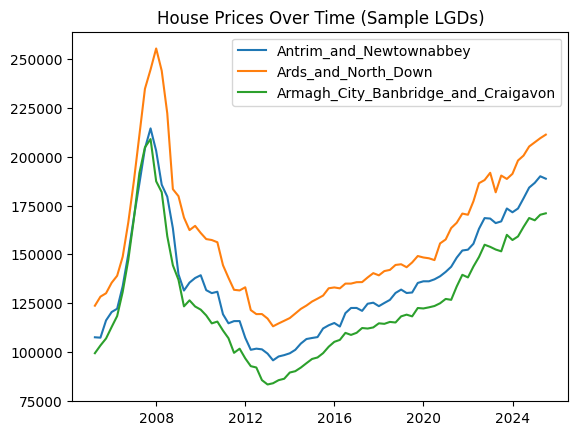

In [181]:
for lgd in df_clean["LGD"].cat.categories[:3]:
    subset = df_clean[df_clean["LGD"] == lgd]
    plt.plot(subset["Period_End"], subset["Standardised_Price"], label=lgd)

plt.legend()
plt.title("House Prices Over Time (Sample LGDs)")
plt.show()

Now we can start preparing the model
For this, we will drop the initial price_lag_1 for the first quarter of LGD for training purposes.

In [215]:
df_model_base = df_clean.dropna(subset=["Price_lag_1"]).copy()

Visualisation Functions

Overall House Pricing Trend

In [216]:
def plot_overall_trend(df: pd.DataFrame):
    overall = (
        df.groupby("Period_End", as_index=False)["Standardised_Price"]
        .mean()
        .sort_values("Period_End")
    )
    plt.figure()
    plt.plot(overall["Period_End"], overall["Standardised_Price"])
    plt.title("House Prices over Time (Overall Trend)")
    plt.xlabel("Time")
    plt.ylabel("Average Standardised Price (£)")
    plt.show()

House Pricing over time by LGD (Local Government District)

In [217]:
def plot_by_lgd_lines(df: pd.DataFrame, max_lgds=15):
    lgds = sorted(df["LGD"].unique())
    if len(lgds) > max_lgds:
        lgds = lgds[:max_lgds]

    plt.figure(figsize=(14, 6))
    for lgd in lgds:
        g = df[df["LGD"] == lgd].sort_values("Period_End")
        plt.plot(g["Period_End"], g["Standardised_Price"], label=lgd)

    plt.title(f"House Prices over time by LGD (Showing {len(lgds)} LGDs)")
    plt.xlabel("Time")
    plt.ylabel("Standardised Price (£)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

Bar Chart with most recent quarter prices by LGD

In [218]:
def plot_lgd_comparison_recent(df: pd.DataFrame):
    last_period = df["Period_End"].max()
    snap = df[df["Period_End"] == last_period][["LGD", "Standardised_Price"]].copy()
    snap = snap.sort_values("Standardised_Price", ascending=False)

    plt.figure()
    plt.bar(snap["LGD"], snap["Standardised_Price"])
    plt.title(f"LGD Comparison (Most Recent: {last_period.date()})")
    plt.xlabel("LGD")
    plt.ylabel("Standardised Price (£)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Growth Rates by LGD (Can choose last n quarters, or from first quarter to last)

In [219]:
def plot_growth_rates_by_lgd(df: pd.DataFrame, method="last_n_quarters", n_quarters=8):
    df = safe_sort(df)

    if method == "first_to_last":
        first_last = df.groupby("LGD").agg(
            first_price=("Standardised_Price", "first"),
            last_price=("Standardised_Price", "last")
        )
        first_last["growth_pct"] = (first_last["last_price"] / first_last["first_price"] - 1.0) * 100.0
        growth = first_last.sort_values("growth_pct", ascending=False).reset_index()

        title = "Growth Rates by LGD (First to Last available)"
    else:
        df["QPeriod"] = df["Period_End"].dt.to_period("Q")
        last_q = df["QPeriod"].max()
        start_q = last_q - (n_quarters -1)

        recent = df[df["QPeriod"].between(start_q, last_q)].copy()
        first_last = recent.groupby("LGD").agg(
            first_price= ("Standardised_Price", "first"),
            last_price= ("Standardised_Price", "last")
        )
        first_last["growth_pct"] = (first_last["last_price"] / first_last["first_price"] - 1.0) * 100.0
        growth = first_last.sort_values("growth_pct", ascending=False).reset_index()

        title = f"Growth Rates by LGD (Last {n_quarters} Quarters: {start_q} to {last_q})"

    plt.figure()
    plt.bar(growth["LGD"], growth["growth_pct"])
    plt.title(title)
    plt.xlabel("LGD")
    plt.ylabel("Growth (%)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print("Top 5 fastest growing LGDs:")
    print(growth.head(5)[["LGD", "growth_pct"]].to_string(index=False))
    print("\nTop 5 slowest growing LGDs:")
    print(growth.tail(5)[["LGD", "growth_pct"]].to_string(index=False))


Heatmap of standardised Prices:

In [220]:
def plot_heatmap(df: pd.DataFrame):
    pivot = df.pivot_table(
        index="LGD"
        , columns="TimeLabel"
        , values="Standardised_Price"
        , aggfunc="mean"
    ).sort_index()

    plt.figure(figsize=(12, 6))
    plt.imshow(pivot.values, aspect="auto")
    plt.title("Heatmap: Standardised Price (Rows: LGD, Columns: Time)")
    plt.xlabel("Time (Quarter)")
    plt.ylabel("LGD")
    plt.xticks(ticks=np.arange(pivot.shape[1]), labels=pivot.columns, rotation=90)
    plt.yticks(ticks=np.arange(pivot.shape[0]), labels=pivot.index)
    plt.tight_layout()
    plt.show()

Training the model (Ridge Regression)

In [221]:
def train_ridge_model(df_model: pd.DataFrame, cutoff_period_end=None, alpha=1.0):
    # Features: LGD (Categorical), Year (Numeric), Quarter (Categorical), Price_lag_1 (Numeric)
    # Training on rows with Period_End <= cutoff_period_end
    # Test on rows with Period_End > cutoff_period_end ( 8 quarters by default)

    df_model = df_model.copy()
    df_model = safe_sort(df_model)

    if cutoff_period_end is None:
        q = df_model["Period_End"].dt.to_period("Q")
        last_q = q.max()
        cutoff_q = last_q - 8
        cutoff_period_end = df_model[q <= cutoff_q]["Period_End"].max()

    train_df = df_model[df_model["Period_End"] <= cutoff_period_end].copy()
    test_df = df_model[df_model["Period_End"] > cutoff_period_end].copy()

    feature_cols = ["LGD", "Year", "Quarter", "Price_lag_1"]
    target_col = "Standardised_Price"

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = test_df[feature_cols]
    y_test = test_df[target_col]

    # One-Hot encoding for LGD and Quarter:
    categorical = ["LGD", "Quarter"]
    numeric = ["Year", "Price_lag_1"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical),
            ("num", "passthrough", numeric)
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("regressor", Ridge(alpha=alpha, random_state=42))
    ])

    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print("Time-aware split cutoff (train <= cutoff):", pd.to_datetime(cutoff_period_end).date())
    print(f"Train rows: {len(train_df):,} | Test rows: {len(test_df):,}")
    print(f"Mean Absolute Error : {mae:,.2f}")
    print(f"Root Mean Square Error : {rmse:,.2f}")
    print(f"R2 : {r2:,.4f}")

    # Add predictions for plotting
    test_df = test_df.copy()
    test_df["Predicted_Price"] = y_pred

    return model, train_df, test_df, cutoff_period_end

model, train_df, test_df, cutoff = train_ridge_model(df_model_base, alpha=5.0)

Time-aware split cutoff (train <= cutoff): 2023-06-30
Train rows: 803 | Test rows: 88
Mean Absolute Error : 3,696.77
Root Mean Square Error : 4,804.71
R2 : 0.9309


Creating the visualisations based on data and predictive model:

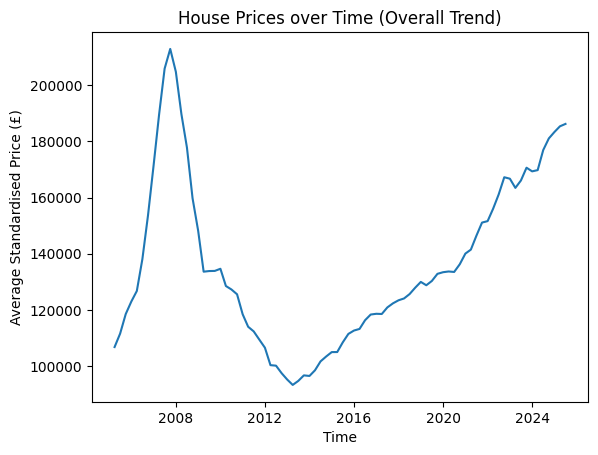

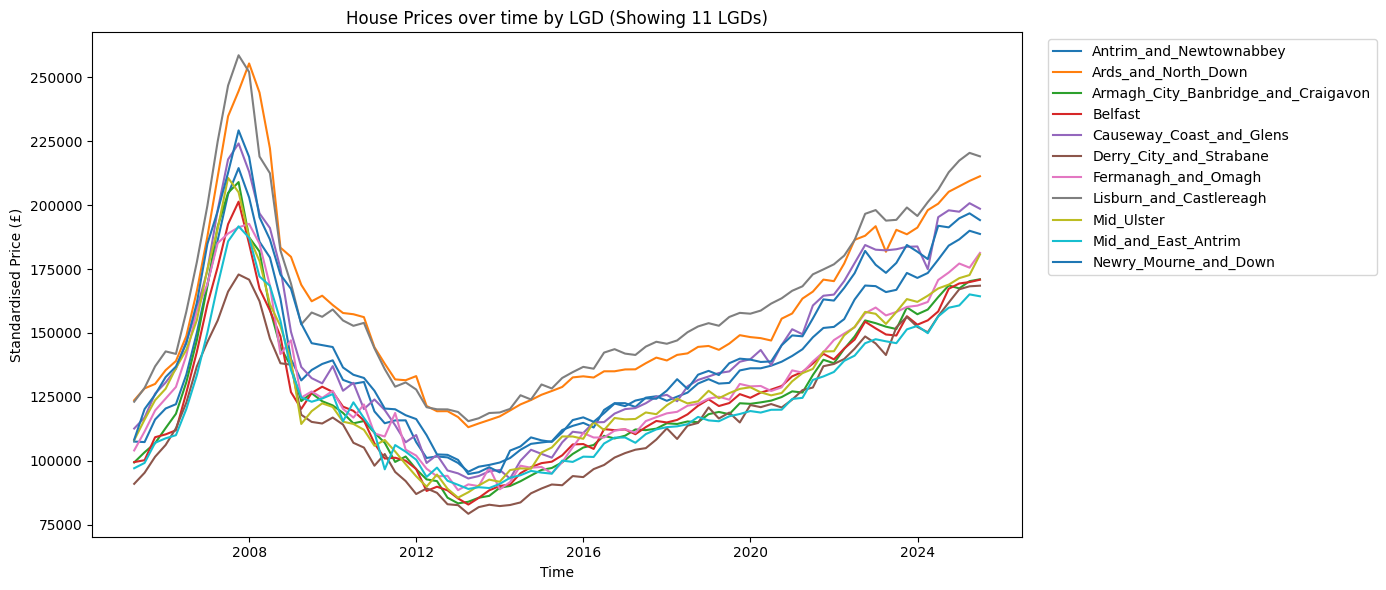

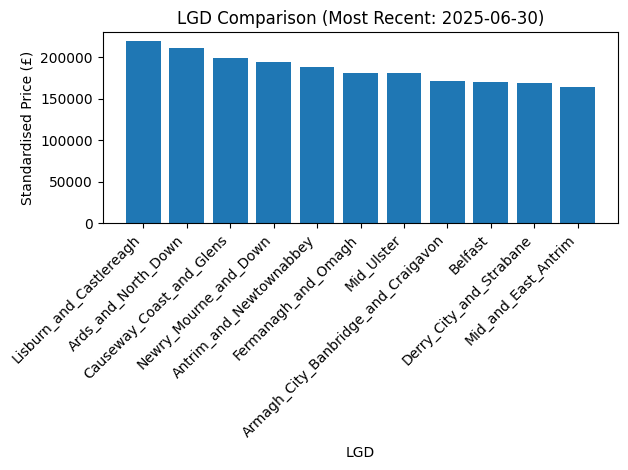

C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\3924054863.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  first_last = recent.groupby("LGD").agg(


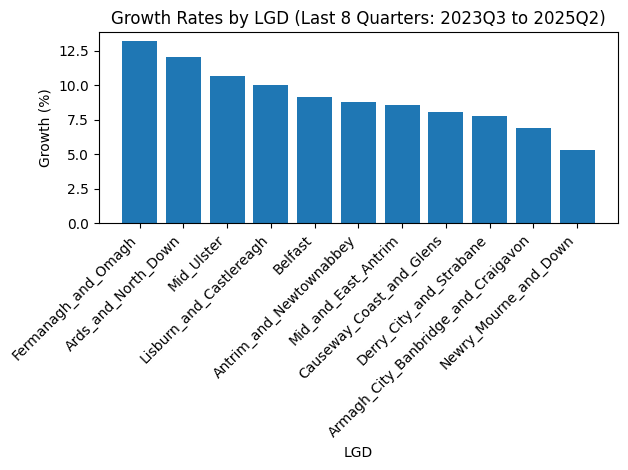

C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\1770552725.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


Top 5 fastest growing LGDs:
                    LGD  growth_pct
    Fermanagh_and_Omagh   13.189333
    Ards_and_North_Down   12.035761
             Mid_Ulster   10.703677
Lisburn_and_Castlereagh   10.055049
                Belfast    9.124391

Top 5 slowest growing LGDs:
                                LGD  growth_pct
                Mid_and_East_Antrim    8.546282
           Causeway_Coast_and_Glens    8.104645
            Derry_City_and_Strabane    7.798939
Armagh_City_Banbridge_and_Craigavon    6.889541
              Newry_Mourne_and_Down    5.281891


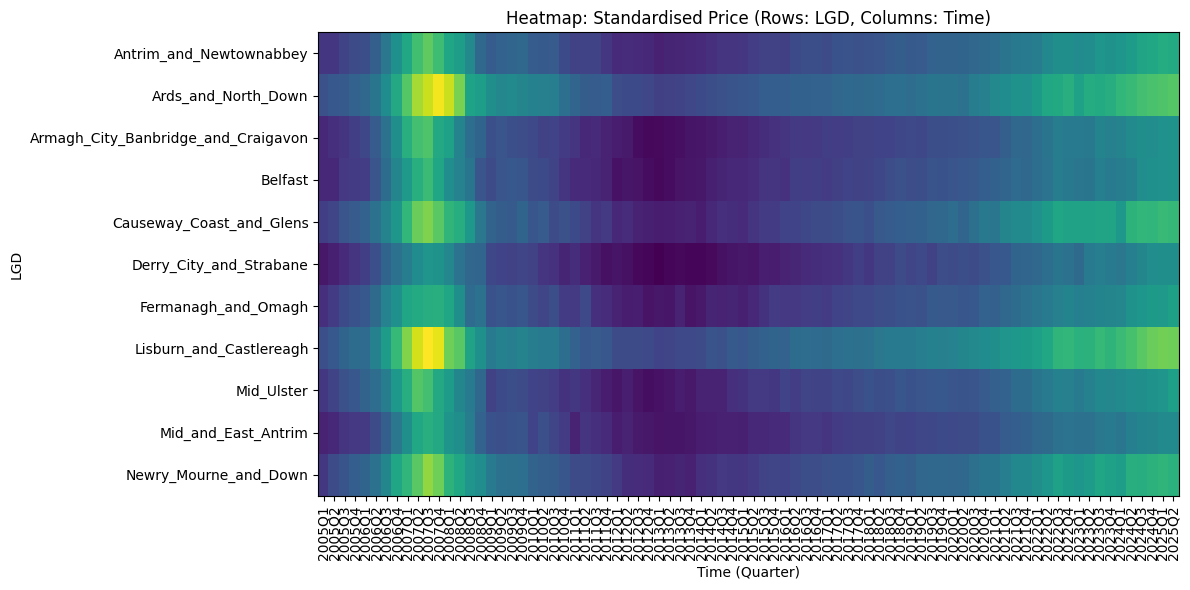

In [222]:
plot_overall_trend(df_clean)
plot_by_lgd_lines(df_clean)
plot_lgd_comparison_recent(df_clean)
plot_growth_rates_by_lgd(df_clean)
plot_heatmap(df_clean)

Plotting the performance of our model:

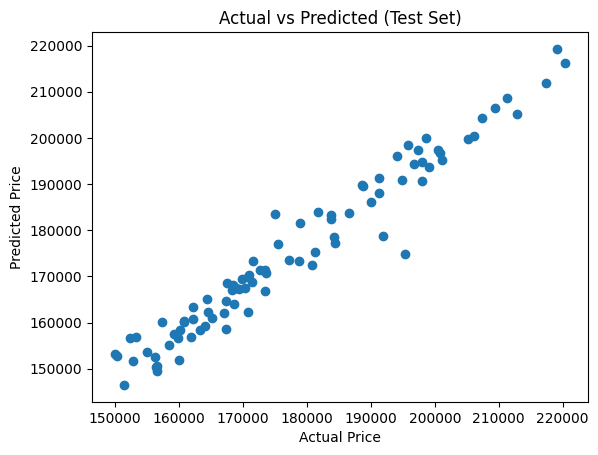

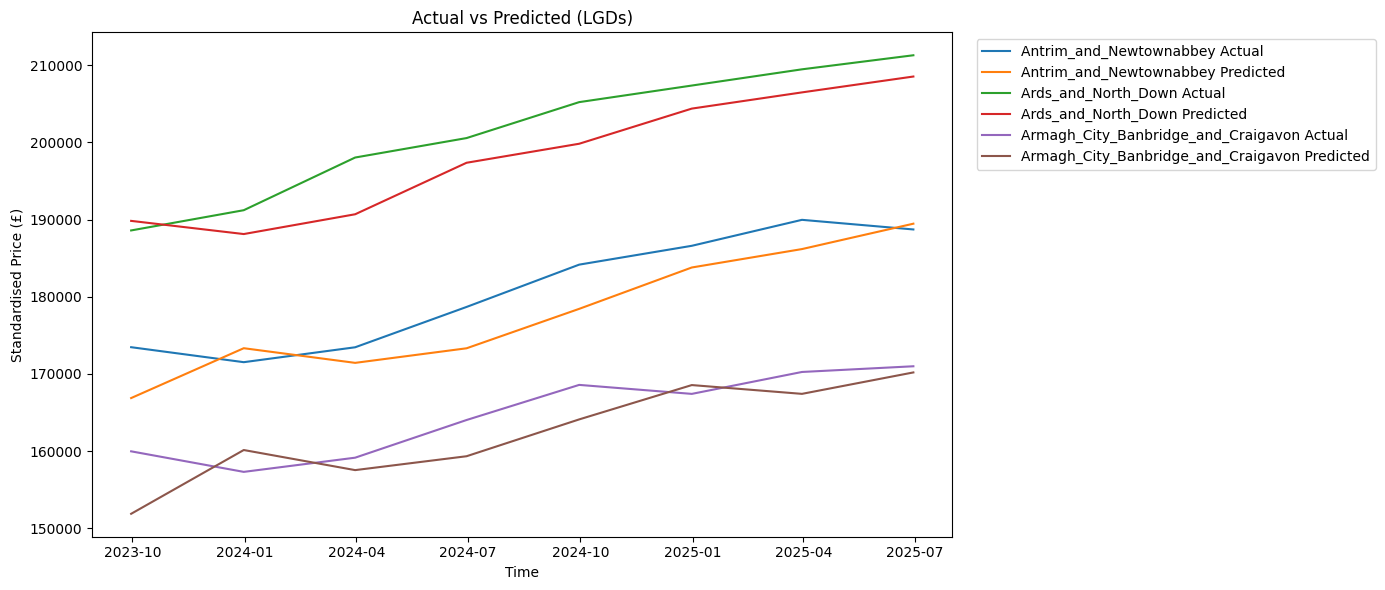

In [225]:
def plot_actual_vs_predicted_scatter(test_df: pd.DataFrame):
    plt.figure()
    plt.scatter(test_df["Standardised_Price"], test_df["Predicted_Price"])
    plt.title("Actual vs Predicted (Test Set)")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.show()

def plot_test_lgd_examples(test_df: pd.DataFrame, lgds=None, n=3):
    if lgds is None:
        lgds = sorted(test_df["LGD"].unique())[:n]
    plt.figure(figsize=(14, 6))
    for lgd in lgds:
        g = test_df[test_df["LGD"] == lgd].sort_values("Period_End")
        plt.plot(g["Period_End"], g["Standardised_Price"], label=f"{lgd} Actual")
        plt.plot(g["Period_End"], g["Predicted_Price"], label=f"{lgd} Predicted")
    plt.title("Actual vs Predicted (LGDs)")
    plt.xlabel("Time")
    plt.ylabel("Standardised Price (£)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted_scatter(test_df)
plot_test_lgd_examples(test_df, n=3)

Forecasting future prices (Overall and by LGD)

In [226]:
def make_future_quarters(last_period_end: pd.Timestamp, n_quarters: int) -> pd.DatetimeIndex:
    start = pd.Period(last_period_end, freq="Q") + 1
    future_periods = [start + i for i in range(n_quarters)]
    return pd.DatetimeIndex([p.end_time.normalize() for p in future_periods])

def forecast_future_prices(
        df_history: pd.DataFrame
        , fitted_model : Pipeline
        , n_quarters_ahead: int=8
) -> pd.DataFrame:
    required_cols = {"Year", "Quarter", "Period_End"}
    missing= required_cols - set(df_history.columns)
    if missing:
        raise ValueError(f"Missing required time columns: {missing}")
    df_history = add_lag_features(df_history)
    df_history = safe_sort(df_history)

    last_period_end = df_history["Period_End"].max()
    future_period_ends = make_future_quarters(last_period_end, n_quarters_ahead)

    lgds = sorted(df_history["LGD"].unique())
    forecasts = []

    last_prices = (
        df_history.sort_values(["LGD", "Period_End"])
        .groupby("LGD", as_index=False)
        .tail(1)[["LGD", "Standardised_Price", "Period_End"]]
        .set_index("LGD")["Standardised_Price"]
        .to_dict()
    )

    for pe in future_period_ends:
        year = pe.year
        quarter = pe.to_period("Q").quarter

        rows = []
        for lgd in lgds:
            rows.append({
                "LGD": lgd
                , "Year" : year
                , "Quarter" : int(quarter)
                , "Price_lag_1" : float(last_prices[lgd])
                , "Period_End" : pe
                , "TimeLabel" : str(pe.to_period("Q"))
            })

        X_future = pd.DataFrame(rows)[["LGD", "Year", "Quarter", "Price_lag_1"]]
        y_future_pred = fitted_model.predict(X_future)

        step_df = pd.DataFrame(rows)
        step_df["Predicted_Price"] = y_future_pred

        # Update the last price for next iteration
        for lgd, pred in zip(step_df["LGD"], step_df["Predicted_Price"]):
            last_prices[lgd] = float(pred)

        forecasts.append(step_df)

    return pd.concat(forecasts, ignore_index=True)

df_forecast = forecast_future_prices(df_clean, model, n_quarters_ahead=8)
df_forecast.head()

C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\561970395.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("LGD", as_index=False)


,LGD,Year,Quarter,Price_lag_1,Period_End,TimeLabel,Predicted_Price
0,Antrim_and_Newtownabbey,2025,3,188728.593549,2025-09-30,2025Q3,188257.243555
1,Ards_and_North_Down,2025,3,211301.467651,2025-09-30,2025Q3,210327.359544
2,Armagh_City_Banbridge_and_Craigavon,2025,3,171000.824534,2025-09-30,2025Q3,170924.319240
3,Belfast,2025,3,170823.114701,2025-09-30,2025Q3,170750.567480
4,Causeway_Coast_and_Glens,2025,3,198589.541078,2025-09-30,2025Q3,197898.561481


Plotting overall future prediction:

In [227]:
def plot_future_overall(df_hist: pd.DataFrame, df_fore: pd.DataFrame):
    hist_overall = (
        df_hist.groupby("Period_End", as_index=False)["Standardised_Price"]
        .mean()
        .sort_values("Period_End")
    )
    fore_overall = (
        df_fore.groupby("Period_End", as_index=False)["Predicted_Price"]
        .mean()
        .sort_values("Period_End")
    )
    
    plt.figure()
    plt.plot(hist_overall["Period_End"], hist_overall["Standardised_Price"], label="Historical (Overall)")
    plt.plot(fore_overall["Period_End"], fore_overall["Predicted_Price"], label="Forecast (Overall)")
    plt.title("Predicting Future Prices (Overall)")
    plt.xlabel("Time")
    plt.ylabel("Average Standardised Price (£)")
    plt.legend()
    plt.show()


Plotting future predictions by LGD

In [229]:
def plot_future_by_lgd(df_hist: pd.DataFrame, df_fore: pd.DataFrame, lgds=None, n=15):
    if lgds is None:
        lgds = sorted(df_hist["LGD"].unique())[:n]
    
    plt.figure(figsize=(14, 6))
    for lgd in lgds:
        h = df_hist[df_hist["LGD"] == lgd].sort_values("Period_End")
        f = df_fore[df_fore["LGD"] == lgd].sort_values("Period_End")

        plt.plot(h["Period_End"], h["Standardised_Price"], label=f"{lgd} Historical")
        plt.plot(f["Period_End"], f["Predicted_Price"], label=f"{lgd} Forecast")

    plt.title("Predicting Future Prices by LGD (Selected)")
    plt.xlabel("Time")
    plt.ylabel("Standardised Price (£)")
    plt.legend(bbox_to_anchor=(1.02, 1))
    plt.tight_layout()
    plt.show()

Finally, using the trained model, we can see on the graph the predicted future pricing for houses in Northern Ireland:

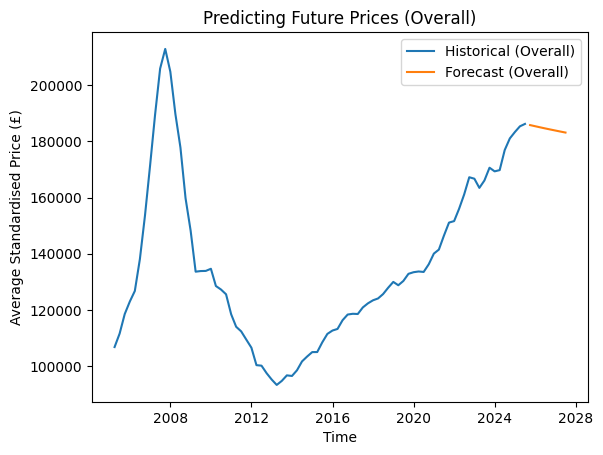

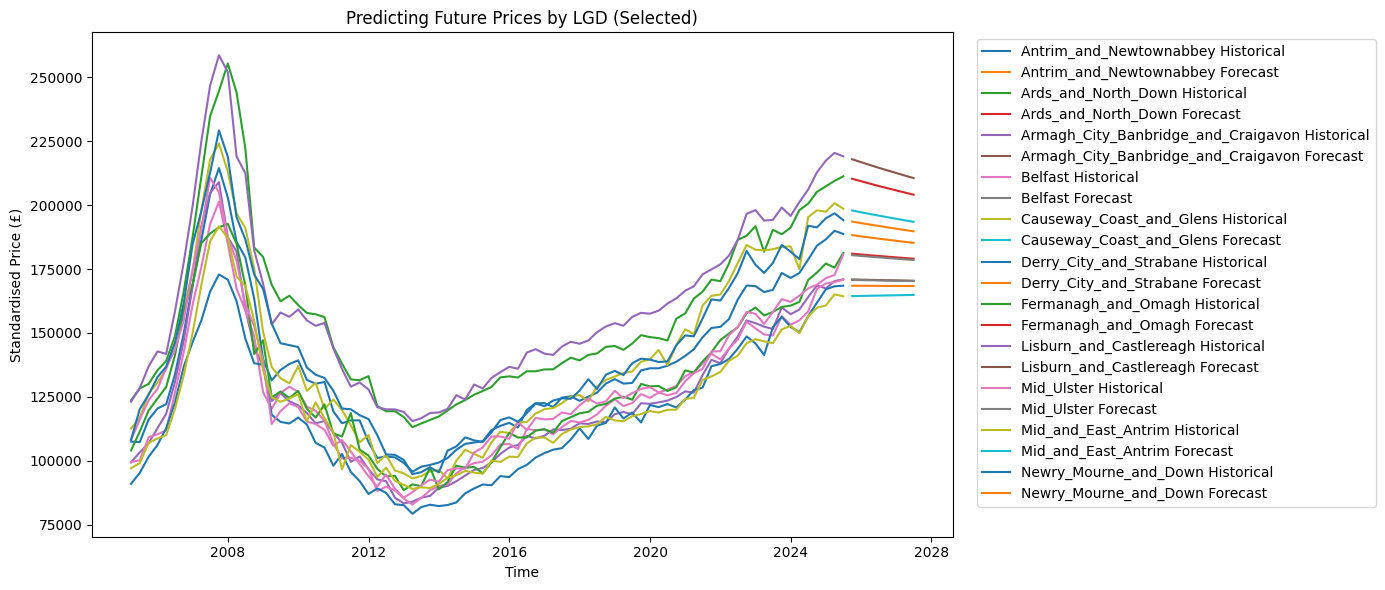

In [230]:
plot_future_overall(df_clean, df_forecast)
plot_future_by_lgd(df_clean, df_forecast)

Saving the prediction dataset to csv:

In [231]:
forecast_path = Path("..\Project\Data\processed\LGD_house_prices_Future_Prediction.csv")
forecast_path.parent.mkdir(parents=True, exist_ok=True)
print(forecast_path.resolve())

df_forecast.to_csv(forecast_path, index=False)

H:\Work\BelfastMET\Course\DSDE\Coursework 1\DSDE-CW1\Project\Data\processed\LGD_house_prices_Future_Prediction.csv


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Nbeat\AppData\Local\Temp\ipykernel_23048\2558449003.py:1: SyntaxWarning: invalid escape sequence '\P'
  forecast_path = Path("..\Project\Data\processed\LGD_house_prices_Future_Prediction.csv")
